<h1><font size=12>
Weather Derivatites </h1>
<h1> Hidden Markov Chain - EM<br></h1>

Developed by [Jesus Solano](mailto:ja.solano588@uniandes.edu.co) <br>  
1 September 2018 


In [104]:
# Import needed libraries. 
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma
import time

## Download Rainfall Data - El dorado Airport

In [3]:
# Download Data

# Configure path to read txts.

path = '../datasets/'

# Download the update dataset.

import os

if not os.path.exists(path+'precipitationAllTime.csv'):

  ! wget https://github.com/jesugome/WeatherDerivates/raw/master/datasets/precipitationAllTime.csv -P path

  ! wget https://github.com/jesugome/WeatherDerivates/raw/master/datasets/precipitationRemovingAverageAllTime.csv -P path


precipitationAllTime = pd.read_csv(path+'precipitationAllTime.csv',header=None, names = ['Date','Prep'])

precipitationReAllTime = pd.read_csv(path+'precipitationRemovingAverageAllTime.csv')

precipitationAllTime['Date'] = pd.to_datetime(precipitationAllTime['Date'])
precipitationAllTime = precipitationAllTime.set_index('Date')


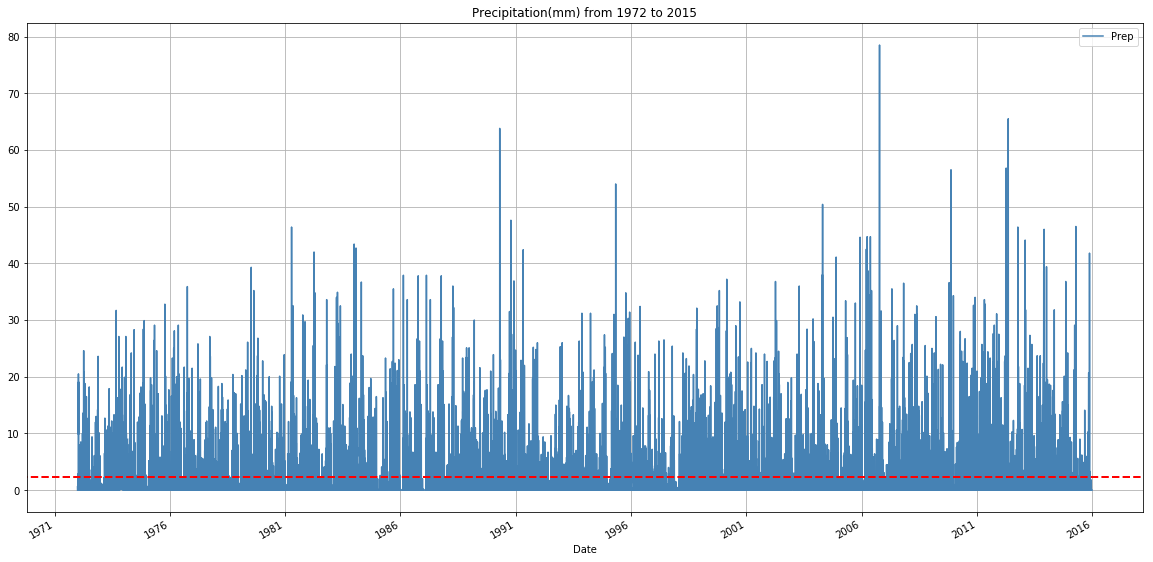

In [4]:
# Plot precipitation over a set of years.

startYear = 1972
endYear = 2015

meanAllTime = precipitationAllTime.mean()
ax = precipitationAllTime.plot(title='Precipitation(mm) from '+ str(startYear) +' to '+str(endYear),figsize=(20,10),grid=True,color='steelblue')
ax.axhline(y=meanAllTime[0], xmin=-1, xmax=1, color='r', linestyle='--', lw=2)

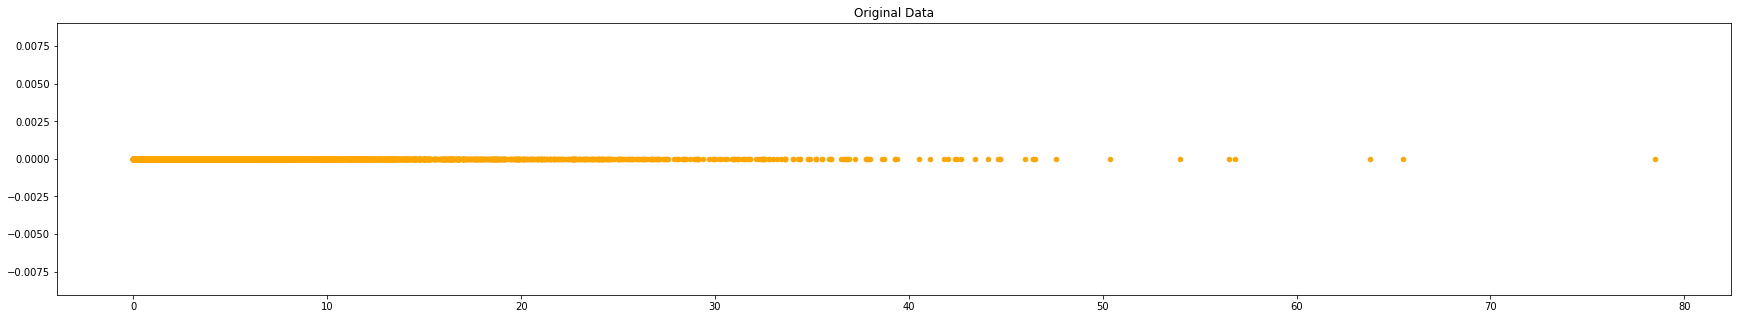

In [13]:
# Data scatter plot. 

fig = plt.figure(figsize=(30, 5))
plt.scatter(precipitationAllTime['Prep'],np.zeros(precipitationAllTime.shape[0]), 20 ,c='orange')
plt.title('Original Data')
plt.show()

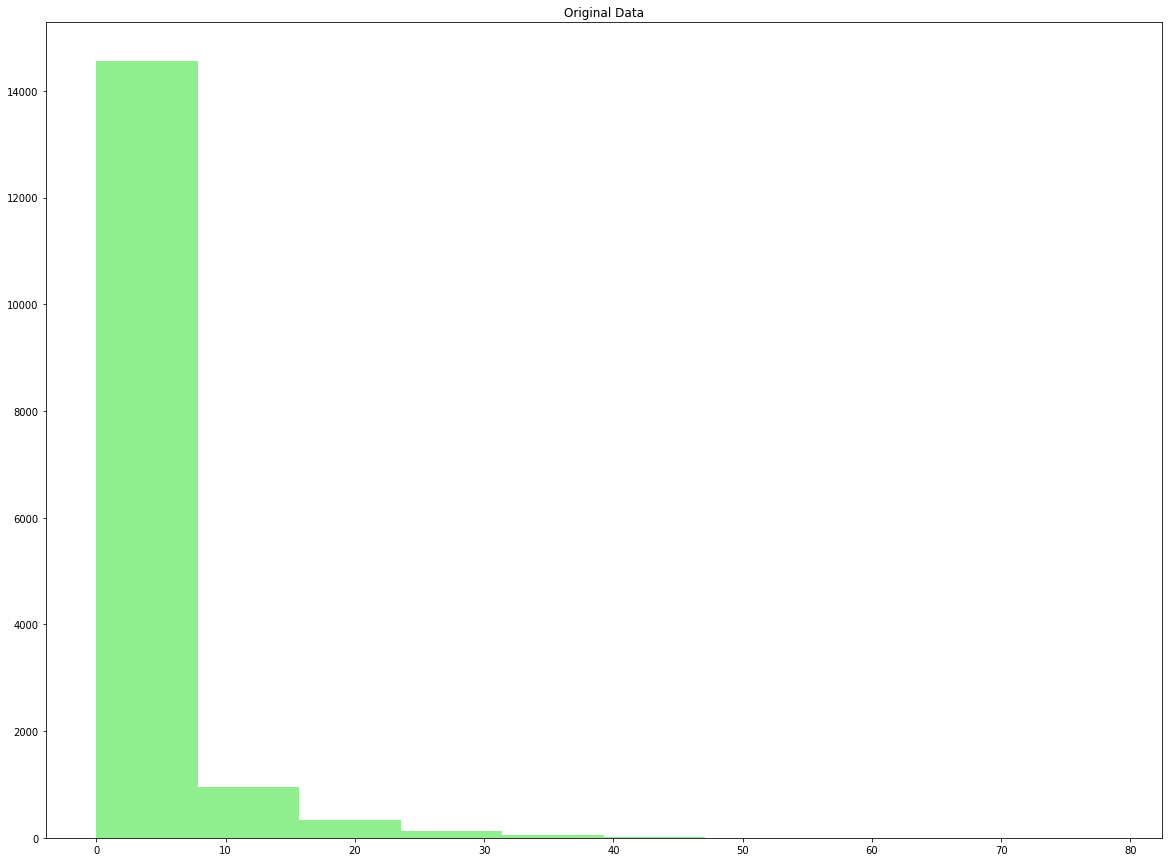

In [15]:
# Data scatter plot. 

fig = plt.figure(figsize=(20, 15))
plt.hist(precipitationAllTime['Prep'],color='lightgreen')
plt.title('Original Data')
plt.show()

# Expectation - Maximization Method 

### EM Functions

In [264]:
# Expectation: assign every data point to its most likely state.

def expectation(data, parameters, numStates, probType):
    
    # Creates an array to store responsabilites for each state.
    statesProb = [None]*numStates
    dataframe = data.copy()
    
    # Loop over historical precipitation. 
    for i in range(dataframe.shape[0]):
        # Get precipitation ammount. 
        precipitation = dataframe['Prep'][i]
        
        for cl in range(numStates):
            
            statesProb[cl] = probabilities(precipitation, parameters['param1'][cl],parameters['param2'][cl],parameters['percentage'][cl], probType)
        
        maxCl = statesProb.index(max(statesProb))
        
        dataframe['state'][i] = maxCl
        
    return dataframe

# Maximization : Updates estimators. 
def maximization(dataframe, parameters, numStates, probType):
    
    dataAssignedToState = [None]* numStates
    percentAssignedToState = [None]* numStates
    
    for cl in range(numStates):
        
        # Find data assigned to state.
        dataAssignedToState[cl] = dataframe[dataframe['state']==cl]
        percentAssignedToState[cl] = len(dataAssignedToState[cl])/ float(len(dataframe))
        
        # Update parameters. 
        parameters['percentage'][cl] = percentAssignedToState[cl]
        
        if probType == 'gamma':
            '''
            Using gamma distribution the meaning of fuction parameters are:
            param1: a
            param2: scale
            percentage : state sample percentage
            '''
            parameters['param2'][cl] = dataAssignedToState[cl]['Prep'].var() / dataAssignedToState[cl]['Prep'].mean() 
            parameters['param1'][cl] = (dataAssignedToState[cl]['Prep'].mean()*dataAssignedToState[cl]['Prep'].mean()) / dataAssignedToState[cl]['Prep'].var() 
        # Case for normal distribution.
        elif probType == 'normal':
            '''
            Using gamma distribution the meaning of fuction parameters are:
            param1: mu
            param2: std
            percentage : state sample percentage
            '''
            parameters['param1'][cl] = dataAssignedToState[cl]['Prep'].mean() 
            parameters['param2'][cl] = dataAssignedToState[cl]['Prep'].std() 
        
    return parameters

# Get the distance between parameters (used for determining if params have converged)
def distance(oldParams, newParams):
    dist = 0
    for param in ['param1', 'param2']:
        for i in range(len(oldParams)):
            dist += (oldParams[param][i] - newParams[param][i]) ** 2
    return dist ** 0.5
        

### EM Iterative Algorithm

In [265]:
# Generator of guess parameters.

def parameterGen(numStates):
    
    percentageList = rand.sample(range(1,10),numStates)

    sumPercentage = sum(percentageList)

    normPercentage = [e / sumPercentage for e in percentageList]

    parameter = {
        'param1': rand.sample(np.arange(1.0,10.0,0.2).tolist(),numStates),
        'param2': rand.sample(np.arange(1.0,10.0,0.2).tolist(),numStates),
        'percentage': normPercentage 

    }
    
    return pd.DataFrame(parameter)



In [266]:
def probabilities(amount, param1, param2, percentage, probType):
    
    # Case for gamma distribution. 
    
    if probType == 'gamma':
        '''
        Using gamma distribution the meaning of fuction parameters are:
        param1: a
        param2: scale
        percentage : state sample percentage
        '''
        aV = param1
        scaleV = param2
        
        prob = percentage*gamma.pdf(amount, aV, scaleV)
  
        return prob        
    
    # Case for normal distribution.
    elif probType == 'normal':
        '''
        Using gamma distribution the meaning of fuction parameters are:
        param1: mu
        param2: std
        percentage : state sample percentage
        '''
        mu = param1
        sig = param2
        
        prob = percentage*norm.pdf(amount, mu, sig)
  
        return prob
        
    else:
        print('Error: Enter a valid distribution.')
    

In [267]:
def EMalgorithm(data, epsilon, param, numStates, probType):
    # Initialization.
    startTime = time.time()
    shift = float("inf")
    iterations = 0
    dataframe = data.copy()
    dataframe['state'] = np.random.choice(numStates,len(dataframe))    
    parameters = param.copy()
    
    # Loop until parameters converge.
    while shift > epsilon: 
        
        iterations += 1

        # Expectation step. 
        
        updatedStates = expectation(dataframe.copy(), parameters, numStates, probType)
               
        # Maximization step. 

        updatedParameters = maximization(updatedStates, parameters.copy(),numStates, probType)


        # Calculate parameters move. 
        shift = distance(parameters, updatedParameters)

        # Logging results.
        currentTime = time.time() - startTime 

        print('Iteration: {} -- Parameter Shift: {:.4f} -- CPU Time: {:.4f} \n'.format(iterations,shift,currentTime))

        print(updatedParameters)

        dataframe = updatedStates

        parameters = updatedParameters

        # Plot states.


        fig = plt.figure(figsize=(20,5))
        plt.scatter(dataframe['Prep'],np.zeros(dataframe.shape[0]), 20, c=dataframe['state'])
        plt.title('Iteration '+str(iterations))
        plt.show()

    
    return dataframe,parameters  
        

In [ ]:
# Two hidden states. 
epsilon= 0.1
numStates= 2
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates2, fittedParameters2 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

Initial parameters are: 
    param1  param2  percentage
0     4.2     1.6    0.857143
1     9.2     1.2    0.142857 



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# Three hidden states. 
epsilon= 0.1
numStates= 3
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates3, fittedParameters3 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

In [ ]:
# Four hidden states. 
epsilon= 0.1
numStates= 4
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates4, fittedParameters4 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

In [ ]:
# Four hidden states. 
epsilon= 0.1
numStates= 4
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates4, fittedParameters4 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

In [ ]:
# Five hidden states. 
epsilon= 0.1
numStates= 5
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates5, fittedParameters5 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

In [ ]:
# Six hidden states. 
epsilon= 0.1
numStates= 6
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates6, fittedParameters6 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )